In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # on mac
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os,sys
import seaborn as sns

import ete3

from helper_scripts import *


In [2]:



plot_params=dict(SAVEPLOT=True,figurefolder='Figures',formats=['.svg'] )

figheight=4

In [3]:
working_dir='AL'

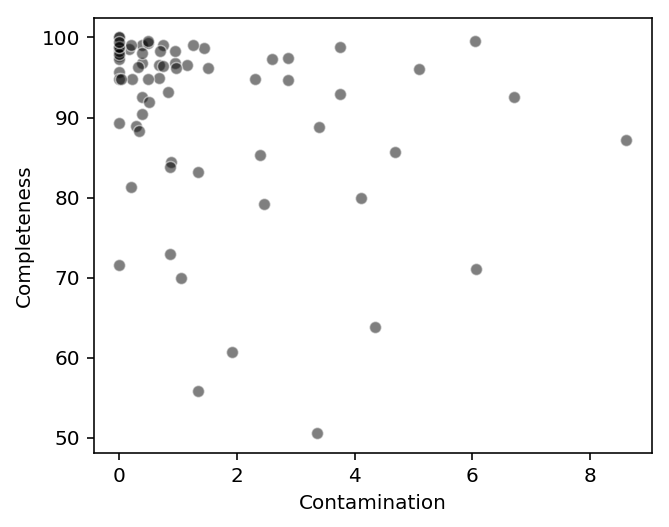

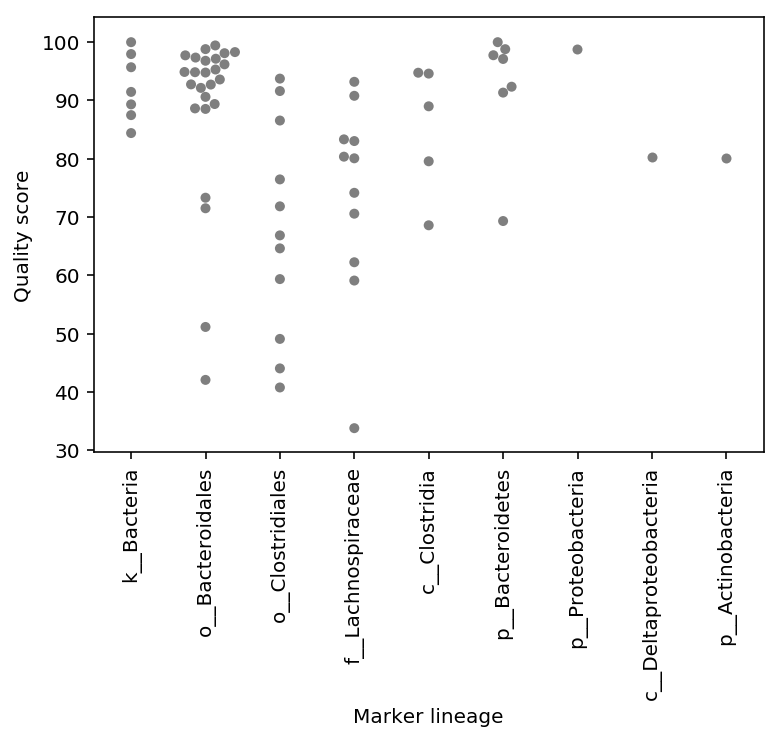

In [4]:
Completeness= pd.read_table(f'{working_dir}/genomes/checkm/completeness.tsv',index_col=0)

f = plt.figure(figsize=(5,figheight))
ax=sns.scatterplot(y=Completeness.Completeness, x= Completeness.Contamination,alpha=0.5,color='k')


saveplot('completness_contamination',**plot_params)


plt.show()


ax=sns.swarmplot(y=Completeness.Completeness -5*Completeness.Contamination,color='k',alpha=0.5,
                 x=Completeness['Marker lineage'].map(lambda s: s.split()[0]))
_ =ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
_ =ax.set_ylabel('Quality score')

## Taxonomy

In [5]:

checkmTax= pd.read_table(f'{working_dir}/genomes/checkm/taxonomy.tsv',index_col=0)


checkmTax = pd.DataFrame(list(checkmTax['Taxonomy (contained)'].apply(lambda s: s.split(';'))),
                       index=checkmTax.index)
checkmTax.columns=['kindom','phylum','class','order','family','genus','species']

checkmTax=checkmTax.fillna(method='ffill',axis=1)

In [6]:
Tax= pd.read_table(f'{working_dir}/genomes/taxonomy/taxonomy.tsv',index_col=0)

Tax=Tax.replace('NoStdName',np.nan).fillna(method='ffill',axis=1)

Labels=Tax.species+' '+Tax.index

In [7]:
phylum= checkmTax.phylum.map(lambda s: s.split('__')[1])

# Tree

In [8]:
from atlas.scripts.utils import tree

T = tree.load_tree(f'{working_dir}/genomes/tree/tree.nwk')

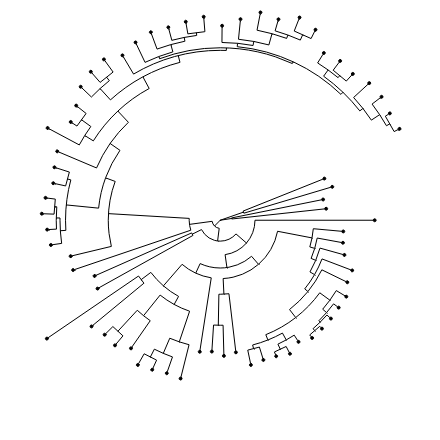

In [9]:
from ete3 import TreeStyle

ts = TreeStyle()
ts.show_leaf_name= False
ts.mode = "c"
ts.scale=200
ts.show_scale=False




T.render("%%inline",tree_style=ts,layout=tree.layout_black_circles)


# Stats based on raw Counts

There are good reasons to use rawcounts and use centric log ratios, see more in 

Gloor, Gregory B., Jean M. Macklaim, Vera Pawlowsky-Glahn, and Juan J. Egozcue. 2017. “Microbiome Datasets Are Compositional: And This Is Not Optional.” Frontiers in Microbiology 8 (November). Frontiers: 2224. doi:10.3389/fmicb.2017.02224.

Raw counts samples x MAGs 

In [10]:
Counts= pd.read_csv(f'{working_dir}/genomes/counts/raw_counts_genomes.tsv',index_col=0,sep='\t')
Counts=Counts.T
Counts.head()

Sample,MAG01,MAG02,MAG03,MAG04,MAG05,MAG06,MAG07,MAG08,MAG09,MAG10,...,MAG60,MAG61,MAG62,MAG63,MAG64,MAG65,MAG66,MAG67,MAG68,MAG69
C1,532,8913,85558,100611,41563,318511,37088,100752,21448,34777,...,50299,26880,37834,30967,157089,7619,3560,17679,4312,60867
C13,197,18007,8882,784486,70002,128642,517,58088,12426,62115,...,46477,113983,124091,58688,180897,17130,26087,19440,14994,161443
C14,226,19770,3757,797582,24518,45427,193,22513,8094,55139,...,15815,155273,32631,50482,149742,12026,8118,20728,14400,139391
C2,369,11054,25992,481991,69543,205274,1660,116274,11955,46803,...,67664,82717,104162,46949,121092,13395,130743,13904,9585,90133
C3,203,12220,2828,354181,37773,94925,423,4250,13431,36248,...,76710,28826,10630,34009,164772,12688,7256,13466,58348,59935


# transforme counts

centrig log ratio

In [11]:
data= Counts.copy()

min_nz_value = data[data>0].min().min()
data=data.replace(0,min_nz_value*0.65).applymap(np.log2)
# normalize by geometrical mean
data= (data.T-data.mean(1)).T


data.index.name='Samples'
data.columns.name='Genomes'

In [12]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

mags= Tax.index


from itertools import combinations

dist=np.array([T.get_distance(*pair) for pair in combinations(mags,2)])

linkage = hc.linkage(dist, method='complete')


## Heatmap

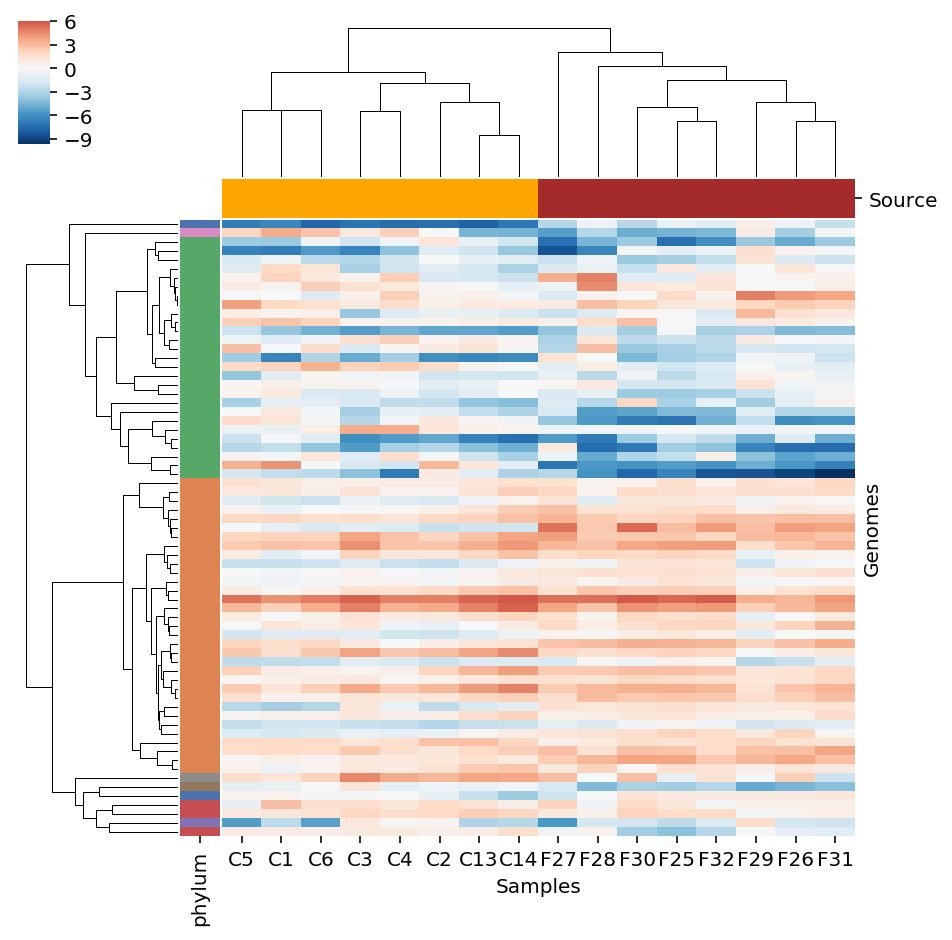

In [13]:
color_map= dict(zip(phylum.unique() ,
               sns.color_palette('deep',n_colors=len(phylum.unique()))
              ))

metadata= pd.DataFrame(index=data.index)
metadata['Source']=metadata.index.str[0].map({'C':'Cecum','F':'Feces'})

cg=sns.clustermap(data.T,figsize=(7.5,7.5),
            row_cluster=True,cmap='RdBu_r', center=0,
             yticklabels= [],#Labels,
            row_linkage=linkage,
               row_colors=phylum.map(color_map),
               col_colors= metadata.Source.map({'Cecum':'orange','Feces':'brown'}),
           
              )

saveplot('heatmap',**plot_params)


## Fraction of mapped reads

In [14]:
read_stats= pd.read_table(f"{working_dir}/stats/read_counts.tsv")
read_stats= read_stats.loc[read_stats.Step=='QC']
read_stats.index=read_stats.Sample

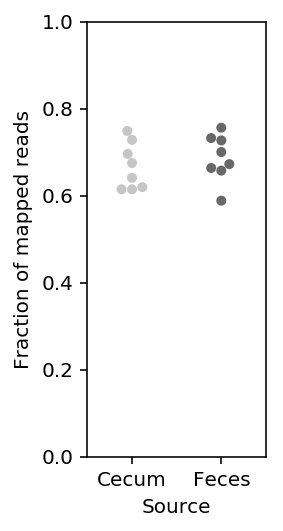

In [15]:
mapped_reads= Counts.sum(1)/ (read_stats.Reads_pe*2+read_stats.Reads_se)
mapped_reads=mapped_reads.dropna()

f= plt.figure(figsize=(figheight/2.5,figheight))
ax= plt.subplot(111)
ax.set_ylim([0,1])
sns.swarmplot(y=mapped_reads,x=metadata.Source,palette='Greys',ax=ax)
ax.set_ylabel('Fraction of mapped reads')

saveplot('Mapping_ratio',**plot_params)


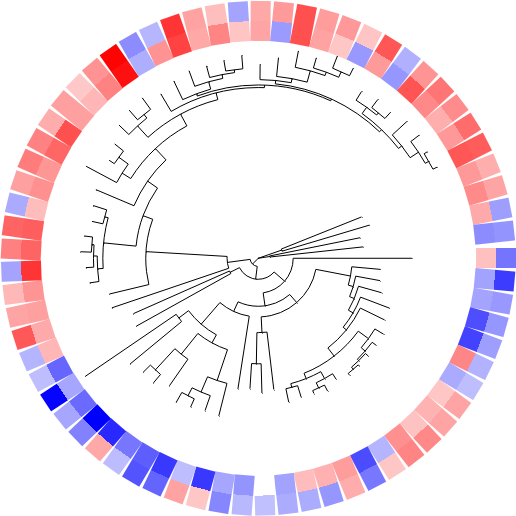

In [16]:
T= ete3.ClusterTree(T.write())

d= data.groupby(metadata.Source).mean().T

#d.columns=d.columns.droplevel(0)

d.index.name='#Names'
T.link_to_arraytable( d.to_csv(sep='\t'))



# nodes are linked to the array table
#array =  t.arraytable


v= d.abs().max().max()

from ete3 import ClusterTree, TreeStyle, AttrFace, ProfileFace, TextFace
from ete3.treeview.faces import add_face_to_node
def heatmap(node):
    node.img_style["size"]=0
    
    # If node is a leaf
    if node.is_leaf():
        # And a line profile
        size=20
        profileFace  = ProfileFace(d.max().max(), d.min().min(), 0,width=size*d.shape[1],height=size ,style= "heatmap")
        add_face_to_node(profileFace, node, 0, aligned=True)


        
ts = TreeStyle()
ts.show_leaf_name= False
ts.mode = "c"
#ts.scale=200
ts.show_scale=False

_= T.render("Figures/tree.svg",tree_style=ts,layout=heatmap)

T.render("%%inline",tree_style=ts,layout=heatmap)

# PCA

In [17]:
from sklearn.decomposition import PCA

pca= PCA()
transformed_data= pca.fit_transform(data)


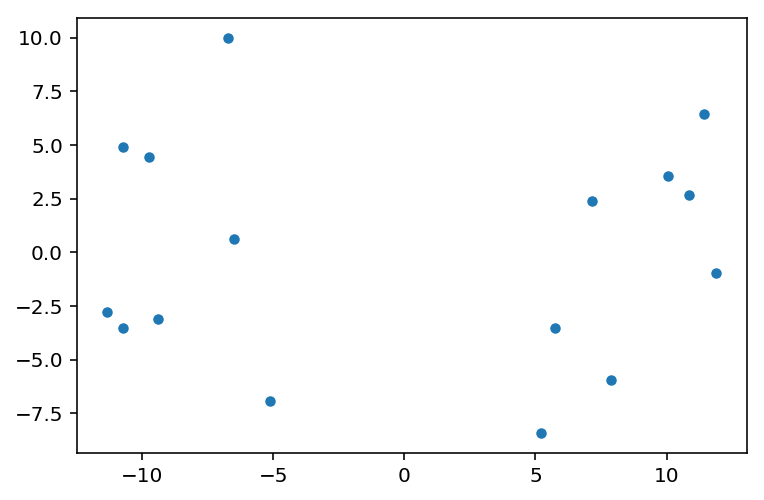

In [18]:
sns.scatterplot(transformed_data[:,0],
                transformed_data[:,1])




# MA plot

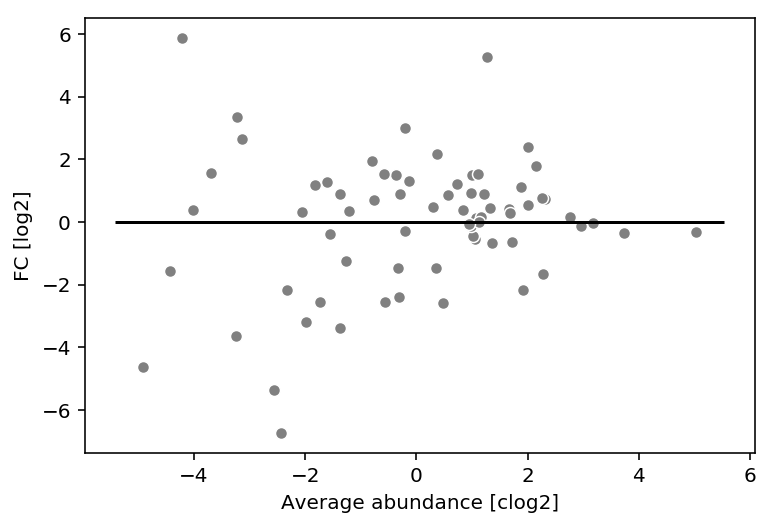

In [19]:
Means= data.groupby(metadata.Source).mean().T


def MA_plot(Abundance,Effect,ax=None,xlabel='Average abundance [clog2]',ylabel='FC [log2]'):
    
    if ax is None:
        ax = plt.subplot(111)

    sns.scatterplot(Abundance,Effect,color='grey',ax=ax)


    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.hlines(0,*ax.get_xlim())
    
    return ax
    
    
MA_plot(Means.mean(1), Means['Feces']-Means['Cecum'])

# Functions

In [20]:
EggNOG= pd.read_table('AL/Genomecatalog/annotations/eggNog.tsv',index_col=0)

bactNOG= EggNOG['Matching_OGs'].str.contains('bactNOG')
bactNOG= EggNOG.loc[bactNOG,'Matching_OGs'].apply(lambda s: [nog for nog in s.split(',') if 'bactNOG' in nog][0])

bactNOG.name='bactNOG'

In [21]:
Clusters= pd.read_table('AL/Genomecatalog/clustering/orf2gene.tsv',sep='\t',index_col=0)
Clusters['Genome']=Clusters.index.map(lambda s: s.split('_')[0])

Clusters= Clusters.join(bactNOG,on='Gene')

#I=Clusters.groupby(['Gene','Genome']).size().unstack().T.fillna(0)
I=Clusters.groupby(['bactNOG','Genome']).size().unstack().T.fillna(0)

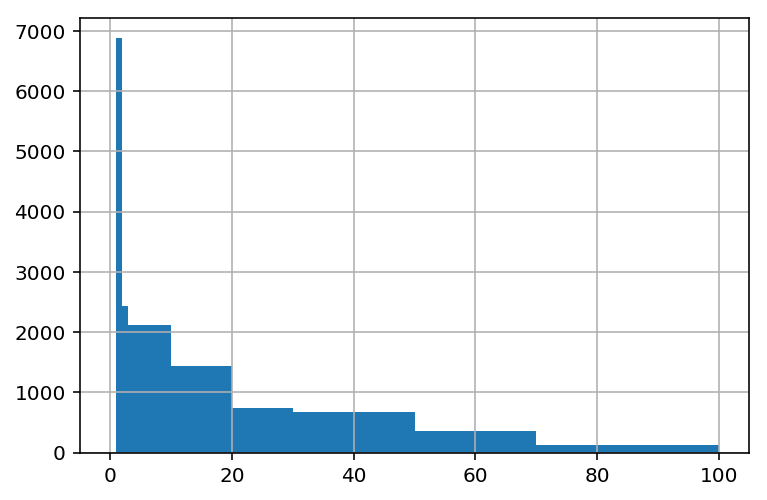

In [22]:
I.sum().hist(bins=[0,1,2,3,5,10,20,30,50,70,100])

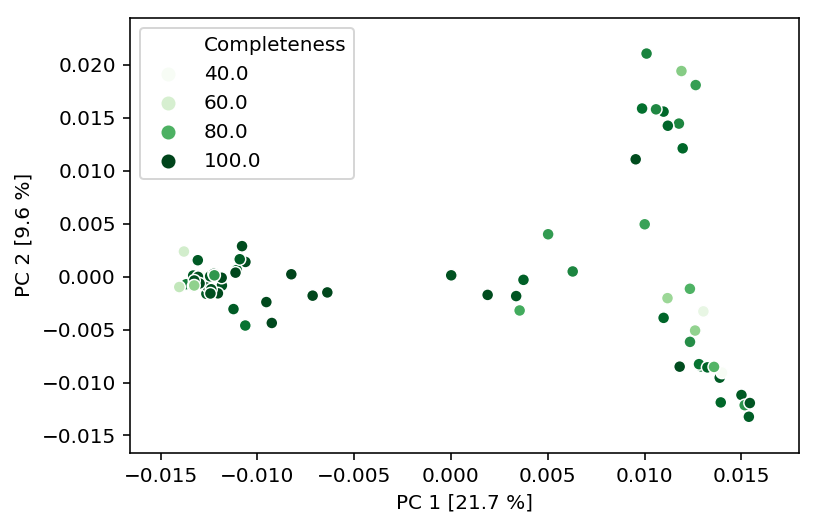

In [24]:


DR =DimensionalReduction((I.T/I.sum(1)).T) #((I.T-I.mean(1))/I.std(1)).T)

pl=DR.plot_Components_2D(hue = Completeness.Completeness,palette='Greens')


plt.show()

/Users/silas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


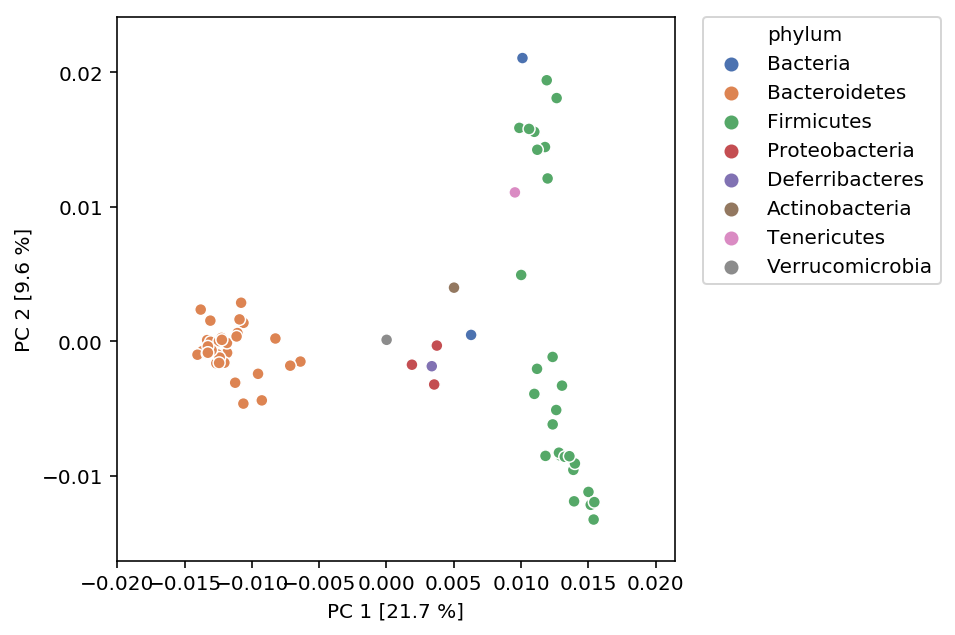

In [25]:
f= plt.figure(figsize=(5,5))
plt.axis('equal')
ax= DR.plot_Components_2D(hue=phylum,palette='deep')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_yticks([-0.01,0,0.01,0.02])

saveplot('PCA_functions',**plot_params)